# data import

In [105]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from itertools import groupby

In [2]:
train = pd.read_csv('data/train.csv')

In [3]:
train.dtypes

building_id        int64
meter              int64
timestamp         object
meter_reading    float64
dtype: object

In [4]:
train['timestamp'] = pd.to_datetime(train['timestamp'])

In [5]:
train.dtypes

building_id               int64
meter                     int64
timestamp        datetime64[ns]
meter_reading           float64
dtype: object

In [6]:
train.shape

(20216100, 4)

# features initial examination

In [7]:
random_places = np.random.randint(0, train.shape[0], (5))
train.iloc[random_places].T

,14420326,11832516,3820719,6851306,15423511
building_id,341,178,503,948,1363
meter,0,1,0,1,2
timestamp,2016-09-19 19:00:00,2016-08-04 12:00:00,2016-03-13 06:00:00,2016-05-07 20:00:00,2016-10-07 12:00:00
meter_reading,330.45,149.466,12.86,63.9715,461.577


In [8]:
np.sum(train.isna())

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

## building id

In [9]:
building_amount = len(train['building_id'].unique())
building_amount

1449

## meter

In [10]:
meter_meaning = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}

In [11]:
train.meter.unique()

array([0, 3, 1, 2], dtype=int64)

In [12]:
train.meter.value_counts()/train.shape[0]

0    0.596599
1    0.206887
2    0.133988
3    0.062526
Name: meter, dtype: float64

In [13]:
meter_amount = train.groupby(by = 'building_id').meter.apply(lambda x: len(np.unique(list(x))))
meter_amount = pd.DataFrame({'amount': meter_amount.values, 'building_id': meter_amount.index})
meter_amount = meter_amount.groupby(by = 'amount').building_id.apply(list)

In [14]:
possible_combinations = {amount: train[train.building_id.isin(meter_amount[amount])].groupby(by = 'building_id').meter
 .apply(lambda x: tuple(np.unique(x))).unique() for amount in range(1, 5)}
possible_combinations

{1: array([(0,), (1,), (2,)], dtype=object),
 2: array([(0, 1), (0, 3), (1, 2), (0, 2)], dtype=object),
 3: array([(0, 1, 3), (0, 1, 2)], dtype=object),
 4: array([(0, 1, 2, 3)], dtype=object)}

In [15]:
meter_amount = train.groupby(by = 'building_id').meter.apply(lambda x: np.unique(list(x)))

## timestamp

In [16]:
last_measure_date = train.groupby(by = 'building_id')['timestamp'].max()
first_measure_date = train.groupby(by = 'building_id')['timestamp'].min()
measure_duration = last_measure_date - first_measure_date
measure_duration = measure_duration.apply(lambda x: x.days)

In [17]:
measure_duration.value_counts()

365    1420
313       3
360       2
144       2
241       1
96        1
110       1
120       1
124       1
127       1
172       1
194       1
217       1
226       1
254       1
364       1
270       1
276       1
289       1
299       1
307       1
331       1
349       1
352       1
358       1
19        1
Name: timestamp, dtype: int64

## meter_reading

In [18]:
np.sum(train['meter_reading'] < 0)

0

[]

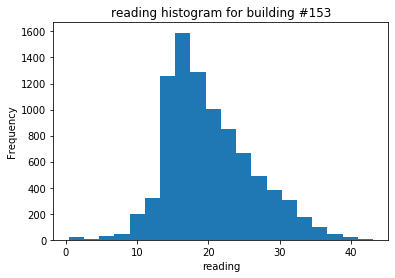

In [19]:
building_id = 153
train[train['building_id'] == building_id]['meter_reading'].plot.hist(bins = 20)
plt.xlabel('reading')
plt.title('reading histogram for building #153')
plt.plot()

[]

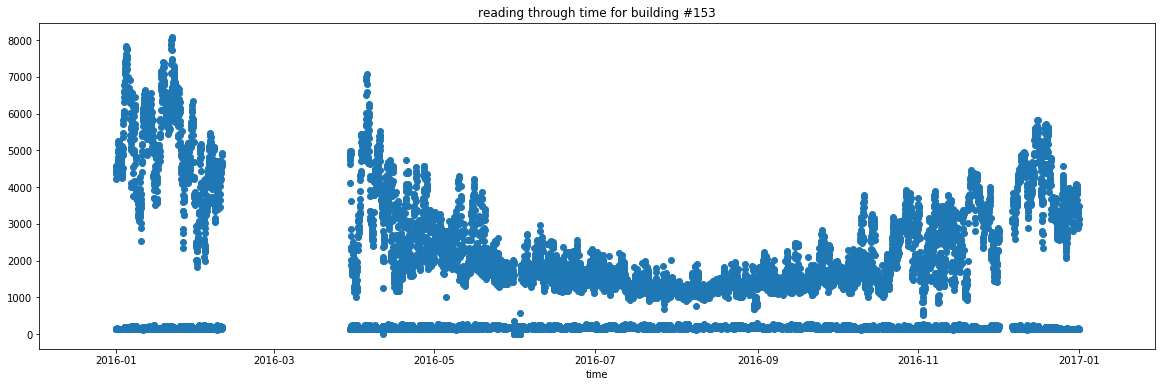

In [20]:
building_id = 1427
fig, ax = plt.subplots(1, 1, figsize = (20, 6))
ax.scatter(train[train['building_id'] == building_id]['timestamp'], train[train['building_id'] == building_id]['meter_reading'])
ax.set_xlabel('time')
ax.set_title('reading through time for building #153')
plt.plot()

# data cleaning

In [7]:
## at the target values as feature, to predict the next values. also adds missing values columns.
building_samples = {}
for key,group in train.groupby('building_id'):
    pivoted_group = group.pivot(index='timestamp',columns='meter',values='meter_reading')
    pivoted_group = pivoted_group.fillna(-1)
    for i in range(4):
        if i not in pivoted_group.columns:
            pivoted_group[i] = -1
    for i in range(4):
        pivoted_group[f'meter_{i}_exists'] = pivoted_group[i].apply(lambda x: 1 if x!=-1 else 0)
    building_samples[key] = pivoted_group

## delete measure samples from before the building started measuring

In [12]:
building_samples[0].head(10)

meter,0,1,2,3,meter_0_exists,meter_1_exists,meter_2_exists,meter_3_exists
timestamp,,,,,,,,
2016-01-01 00:00:00,0.0,-1,-1,-1,1,0,0,0
2016-01-01 01:00:00,0.0,-1,-1,-1,1,0,0,0
2016-01-01 02:00:00,0.0,-1,-1,-1,1,0,0,0
2016-01-01 03:00:00,0.0,-1,-1,-1,1,0,0,0
2016-01-01 04:00:00,0.0,-1,-1,-1,1,0,0,0
2016-01-01 05:00:00,0.0,-1,-1,-1,1,0,0,0
2016-01-01 06:00:00,0.0,-1,-1,-1,1,0,0,0
2016-01-01 07:00:00,0.0,-1,-1,-1,1,0,0,0
2016-01-01 08:00:00,0.0,-1,-1,-1,1,0,0,0


In [54]:
for k in building_samples.keys():
    if k%20 == 0:
        print(k)
    start_time = np.argmax(building_samples[k].apply(lambda row: np.max([row[0], row[1], row[2], row[3]]), axis = 1) > 0)
    before_measurement = building_samples[k].index < start_time
    building_samples[k].drop(building_samples[k].index[before_measurement], inplace = True)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440


## fill all hours

In [55]:
df = building_samples[0]

In [76]:
{k: len(set(all_dates) - set(building_samples[k].index)) for k in building_samples.keys()}

{0: 704,
 1: 37,
 2: 33,
 3: 2923,
 4: 689,
 5: 85,
 6: 2923,
 7: 1425,
 8: 2923,
 9: 1425,
 10: 2923,
 11: 89,
 12: 619,
 13: 1425,
 14: 509,
 15: 1425,
 16: 351,
 17: 2923,
 18: 752,
 19: 2923,
 20: 1,
 21: 717,
 22: 713,
 23: 2923,
 24: 2923,
 25: 2923,
 26: 2923,
 27: 2923,
 28: 2487,
 29: 1416,
 30: 1425,
 31: 1425,
 32: 2923,
 33: 1150,
 34: 2923,
 35: 1089,
 36: 2923,
 37: 2923,
 38: 593,
 39: 2923,
 40: 3707,
 41: 2923,
 42: 2923,
 43: 329,
 44: 2923,
 45: 4357,
 46: 0,
 47: 2924,
 48: 1433,
 49: 2923,
 50: 1425,
 51: 2923,
 52: 41,
 53: 7104,
 54: 11,
 55: 1425,
 56: 2923,
 57: 2923,
 58: 2923,
 59: 2923,
 60: 2734,
 61: 2923,
 62: 2923,
 63: 695,
 64: 2923,
 65: 1229,
 66: 2923,
 67: 2923,
 68: 2130,
 69: 545,
 70: 19,
 71: 1000,
 72: 2923,
 73: 747,
 74: 0,
 75: 1425,
 76: 739,
 77: 2923,
 78: 31,
 79: 2923,
 80: 2923,
 81: 2923,
 82: 1425,
 83: 901,
 84: 2923,
 85: 2923,
 86: 1519,
 87: 2923,
 88: 2923,
 89: 479,
 90: 2923,
 91: 27,
 92: 1425,
 93: 0,
 94: 71,
 95: 237,
 96

In [67]:
all_dates = pd.date_range(start='1/1/2016', end = '31/12/2016', freq='H')

In [71]:
all_dates

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 02:00:00', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00', '2016-01-01 05:00:00',
               '2016-01-01 06:00:00', '2016-01-01 07:00:00',
               '2016-01-01 08:00:00', '2016-01-01 09:00:00',
               ...
               '2016-12-30 15:00:00', '2016-12-30 16:00:00',
               '2016-12-30 17:00:00', '2016-12-30 18:00:00',
               '2016-12-30 19:00:00', '2016-12-30 20:00:00',
               '2016-12-30 21:00:00', '2016-12-30 22:00:00',
               '2016-12-30 23:00:00', '2016-12-31 00:00:00'],
              dtype='datetime64[ns]', length=8761, freq='H')

In [83]:
for k in building_samples.keys():
    print(k)
    missing_times = list(set(all_dates) - set(building_samples[k].index))
    for time in missing_times:
        building_samples[k].loc[time] = [-1, -1, -1, -1, 0, 0, 0, 0]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [100]:
np.all([len(building_samples[k].index) > 8760 for k in building_samples.keys()])

True

## detect big missing times

In [102]:
for k in building_samples.keys():
    if k%20 == 0:
        print(k)
    building_samples[k]['any_exists'] = building_samples[k].apply(
        lambda row: np.max([row['meter_0_exists'], row['meter_1_exists'], row['meter_2_exists'], row['meter_3_exists']]),
        axis = 1)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440


In [122]:
a = [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1]
max(0 if _ == 0 else sum(1 for i in g) for _,g in groupby(a))

3

In [128]:
max_stop = {k: max(0 if _ == 1 else sum(1 for i in g) for _,g in groupby(building_samples[k]['any_exists']))
            for k in building_samples.keys()}
max_stop = {k: v for k, v in sorted(max_stop.items(), key=lambda item: item[1], reverse = True)}
max_stop

{403: 8305,
 604: 8057,
 1221: 7404,
 53: 7104,
 783: 6999,
 420: 6434,
 591: 6037,
 1024: 5780,
 621: 5722,
 568: 5486,
 647: 5456,
 567: 5319,
 954: 5291,
 1113: 5003,
 45: 4357,
 555: 4127,
 40: 3707,
 528: 3553,
 1281: 3351,
 607: 3098,
 602: 3071,
 47: 2924,
 101: 2924,
 3: 2923,
 6: 2923,
 8: 2923,
 10: 2923,
 17: 2923,
 19: 2923,
 23: 2923,
 24: 2923,
 25: 2923,
 26: 2923,
 27: 2923,
 32: 2923,
 34: 2923,
 36: 2923,
 37: 2923,
 39: 2923,
 41: 2923,
 42: 2923,
 44: 2923,
 49: 2923,
 51: 2923,
 56: 2923,
 57: 2923,
 58: 2923,
 59: 2923,
 61: 2923,
 62: 2923,
 64: 2923,
 66: 2923,
 67: 2923,
 72: 2923,
 77: 2923,
 79: 2923,
 80: 2923,
 81: 2923,
 84: 2923,
 85: 2923,
 87: 2923,
 88: 2923,
 90: 2923,
 98: 2923,
 99: 2923,
 100: 2923,
 102: 2923,
 104: 2923,
 681: 2784,
 60: 2734,
 487: 2666,
 1005: 2646,
 1006: 2578,
 28: 2487,
 1397: 2440,
 1072: 2176,
 613: 2166,
 68: 2130,
 1349: 2115,
 626: 2094,
 341: 1826,
 593: 1601,
 625: 1578,
 86: 1519,
 861: 1512,
 1372: 1452,
 1374: 1452

In [153]:
max_stop = {403: 8305, 604: 8057, 1221: 7404, 53: 7104, 783: 6999, 420: 6434, 591: 6037, 1024: 5780, 621: 5722, 568: 5486, 647: 5456, 567: 5319, 954: 5291, 1113: 5003, 45: 4357, 555: 4127, 40: 3707, 528: 3553, 1281: 3351, 607: 3098, 602: 3071, 47: 2924, 101: 2924, 3: 2923, 6: 2923, 8: 2923, 10: 2923, 17: 2923, 19: 2923, 23: 2923, 24: 2923, 25: 2923, 26: 2923, 27: 2923, 32: 2923, 34: 2923, 36: 2923, 37: 2923, 39: 2923, 41: 2923, 42: 2923, 44: 2923, 49: 2923, 51: 2923, 56: 2923, 57: 2923, 58: 2923, 59: 2923, 61: 2923, 62: 2923, 64: 2923, 66: 2923, 67: 2923, 72: 2923, 77: 2923, 79: 2923, 80: 2923, 81: 2923, 84: 2923, 85: 2923, 87: 2923, 88: 2923, 90: 2923, 98: 2923, 99: 2923, 100: 2923, 102: 2923, 104: 2923, 681: 2784, 60: 2734, 487: 2666, 1005: 2646, 1006: 2578, 28: 2487, 1397: 2440, 1072: 2176, 613: 2166, 68: 2130, 1349: 2115, 626: 2094, 341: 1826, 593: 1601, 625: 1578, 86: 1519, 861: 1512, 1372: 1452, 1374: 1452, 1388: 1452, 48: 1433, 7: 1425, 9: 1425, 13: 1425, 15: 1425, 30: 1425, 31: 1425, 50: 1425, 55: 1425, 75: 1425, 82: 1425, 92: 1425, 29: 1416, 1428: 1404, 1444: 1339, 1445: 1335, 1448: 1332, 1429: 1328, 1423: 1324, 752: 1323, 786: 1322, 1446: 1320, 1325: 1318, 1371: 1318, 1373: 1318, 583: 1317, 1440: 1316, 1370: 1314, 1441: 1314, 1385: 1313, 1447: 1313, 1327: 1312, 1330: 1312, 1335: 1312, 1338: 1312, 1340: 1312, 1346: 1312, 1356: 1312, 1360: 1312, 1364: 1312, 1365: 1312, 1369: 1312, 1378: 1312, 1387: 1312, 1392: 1312, 1393: 1312, 1399: 1312, 1402: 1312, 1403: 1312, 1406: 1312, 1414: 1312, 1415: 1312, 1416: 1312, 1417: 1312, 1418: 1312, 1419: 1312, 1420: 1312, 1421: 1312, 1422: 1312, 1424: 1312, 1425: 1312, 1426: 1312, 1427: 1312, 1430: 1312, 1431: 1312, 1432: 1312, 1433: 1312, 1434: 1312, 1435: 1312, 1436: 1312, 1437: 1312, 1438: 1312, 1439: 1312, 1442: 1312, 1443: 1312, 1405: 1305, 376: 1298, 469: 1285, 763: 1285, 65: 1229, 757: 1225, 839: 1225, 1014: 1192, 1413: 1191, 1390: 1185, 1412: 1170, 1362: 1163, 1395: 1163, 1410: 1163, 1326: 1162, 1328: 1162, 1329: 1162, 1331: 1162, 1332: 1162, 1333: 1162, 1334: 1162, 1336: 1162, 1337: 1162, 1339: 1162, 1341: 1162, 1342: 1162, 1343: 1162, 1344: 1162, 1345: 1162, 1347: 1162, 1348: 1162, 1350: 1162, 1351: 1162, 1352: 1162, 1353: 1162, 1354: 1162, 1355: 1162, 1357: 1162, 1358: 1162, 1359: 1162, 1361: 1162, 1363: 1162, 1366: 1162, 1367: 1162, 1368: 1162, 1375: 1162, 1376: 1162, 1377: 1162, 1379: 1162, 1380: 1162, 1381: 1162, 1382: 1162, 1383: 1162, 1384: 1162, 1386: 1162, 1389: 1162, 1391: 1162, 1394: 1162, 1396: 1162, 1398: 1162, 1401: 1162, 1404: 1162, 1407: 1162, 1408: 1162, 1409: 1162, 1411: 1162, 840: 1153, 986: 1151, 33: 1150, 904: 1144, 847: 1129, 35: 1089, 772: 1039, 849: 1033, 816: 1032, 809: 1009, 819: 1009, 829: 1009, 71: 1000, 827: 985, 852: 985, 860: 984, 814: 961, 872: 961, 811: 937, 838: 937, 850: 937, 871: 937, 873: 937, 808: 936, 804: 913, 824: 913, 83: 901, 842: 889, 870: 889, 855: 888, 812: 865, 813: 865, 820: 865, 832: 865, 868: 841, 844: 825, 299: 819, 857: 811, 751: 807, 828: 798, 909: 797, 413: 770, 18: 752, 73: 747, 76: 739, 845: 720, 21: 717, 22: 713, 0: 704, 63: 695, 4: 689, 858: 625, 12: 619, 863: 601, 853: 600, 38: 593, 69: 545, 810: 529, 815: 529, 14: 509, 89: 479, 1153: 471, 841: 457, 805: 433, 822: 433, 830: 433, 833: 433, 848: 433, 859: 433, 862: 433, 867: 433, 846: 409, 834: 385, 851: 385, 837: 384, 182: 381, 545: 362, 806: 361, 823: 361, 825: 361, 856: 361, 865: 361, 866: 361, 16: 351, 296: 346, 999: 338, 807: 337, 817: 337, 818: 337, 826: 337, 831: 337, 835: 337, 836: 337, 843: 337, 864: 337, 869: 337, 43: 329, 1028: 322, 821: 313, 611: 308, 1222: 295, 522: 294, 544: 266, 1002: 266, 854: 265, 649: 255, 492: 242, 95: 237, 635: 214, 601: 212, 1004: 211, 950: 210, 298: 202, 789: 194, 790: 194, 1060: 192, 792: 188, 160: 174, 566: 160, 1194: 158, 1077: 157, 877: 153, 970: 152, 892: 150, 985: 148, 300: 147, 881: 144, 1007: 135, 1400: 133, 514: 127, 483: 122, 500: 122, 546: 122, 637: 109, 943: 96, 292: 92, 1030: 92, 1059: 92, 1031: 91, 11: 89, 5: 85, 103: 75, 449: 75, 518: 74, 560: 74, 521: 73, 519: 72, 572: 72, 94: 71, 768: 63, 1131: 62, 644: 61, 533: 57, 654: 52, 318: 50, 332: 50, 352: 50, 515: 50, 537: 50, 579: 49, 582: 48, 164: 47, 524: 47, 590: 47, 97: 43, 52: 41, 366: 41, 165: 40, 251: 39, 553: 38, 1: 37, 651: 37, 606: 34, 2: 33, 78: 31, 508: 31, 1019: 29, 91: 27, 354: 27, 551: 27, 556: 27, 291: 26, 297: 26, 306: 26, 311: 26, 314: 26, 325: 26, 326: 26, 328: 26, 333: 26, 334: 26, 338: 26, 344: 26, 345: 26, 347: 26, 348: 26, 349: 26, 351: 26, 353: 26, 355: 26, 357: 26, 358: 26, 360: 26, 361: 26, 364: 26, 377: 26, 380: 26, 381: 26, 382: 26, 383: 26, 385: 26, 386: 26, 387: 26, 389: 26, 391: 26, 397: 26, 398: 26, 410: 26, 421: 26, 423: 26, 439: 26, 448: 26, 450: 26, 451: 26, 452: 26, 456: 26, 459: 26, 460: 26, 462: 26, 470: 26, 476: 26, 477: 26, 481: 26, 486: 26, 488: 26, 491: 26, 497: 26, 498: 26, 503: 26, 507: 26, 510: 26, 523: 26, 527: 26, 535: 26, 539: 26, 540: 26, 541: 26, 548: 26, 550: 26, 558: 26, 754: 25, 897: 25, 1020: 24, 1215: 24, 374: 23, 653: 23, 936: 23, 937: 23, 775: 22, 919: 22, 938: 22, 517: 21, 902: 21, 930: 21, 935: 21, 1026: 21, 270: 20, 982: 20, 1011: 20, 70: 19, 882: 19, 940: 19, 944: 19, 984: 19, 399: 18, 762: 18, 884: 18, 939: 18, 947: 18, 988: 18, 1010: 18, 942: 17, 1015: 17, 941: 16, 1001: 16, 575: 15, 874: 15, 979: 15, 1000: 15, 1025: 15, 321: 14, 619: 14, 894: 14, 962: 14, 883: 13, 975: 13, 1023: 13, 648: 12, 917: 12, 951: 12, 981: 12, 54: 11, 159: 11, 600: 11, 971: 11, 987: 11, 1008: 11, 1009: 11, 1016: 11, 1027: 11, 185: 10, 652: 10, 761: 10, 785: 10, 927: 10, 998: 10, 1012: 10, 1013: 10, 1017: 10, 1018: 10, 1040: 10, 402: 9, 587: 9, 596: 9, 632: 9, 645: 9, 756: 9, 773: 9, 788: 9, 890: 9, 905: 9, 924: 9, 964: 9, 968: 9, 1003: 9, 1021: 9, 1022: 9, 1029: 9, 746: 8, 749: 8, 760: 8, 779: 8, 878: 8, 889: 8, 901: 8, 915: 8, 921: 8, 952: 8, 953: 8, 615: 7, 641: 7, 748: 7, 899: 7, 914: 7, 925: 7, 928: 7, 933: 7, 1071: 7, 1116: 7, 636: 6, 879: 6, 906: 6, 911: 6, 929: 6, 945: 6, 955: 6, 965: 6, 966: 6, 969: 6, 983: 6, 992: 6, 993: 6, 995: 6, 1128: 6, 1190: 6, 350: 5, 494: 5, 581: 5, 592: 5, 612: 5, 876: 5, 880: 5, 885: 5, 891: 5, 893: 5, 896: 5, 900: 5, 903: 5, 910: 5, 913: 5, 916: 5, 922: 5, 923: 5, 926: 5, 931: 5, 946: 5, 949: 5, 957: 5, 958: 5, 963: 5, 967: 5, 973: 5, 974: 5, 977: 5, 980: 5, 989: 5, 990: 5, 991: 5, 1038: 5, 305: 4, 565: 4, 633: 4, 795: 4, 875: 4, 887: 4, 888: 4, 898: 4, 907: 4, 908: 4, 912: 4, 918: 4, 920: 4, 932: 4, 934: 4, 948: 4, 956: 4, 959: 4, 960: 4, 961: 4, 972: 4, 976: 4, 978: 4, 994: 4, 1115: 4, 1120: 4, 96: 3, 173: 3, 174: 3, 177: 3, 178: 3, 179: 3, 180: 3, 181: 3, 183: 3, 186: 3, 187: 3, 188: 3, 189: 3, 190: 3, 191: 3, 192: 3, 193: 3, 194: 3, 195: 3, 196: 3, 197: 3, 198: 3, 199: 3, 200: 3, 201: 3, 202: 3, 203: 3, 204: 3, 205: 3, 207: 3, 209: 3, 210: 3, 211: 3, 212: 3, 213: 3, 214: 3, 215: 3, 256: 3, 280: 3, 342: 3, 434: 3, 474: 3, 496: 3, 506: 3, 627: 3, 630: 3, 650: 3, 781: 3, 782: 3, 796: 3, 797: 3, 798: 3, 799: 3, 800: 3, 801: 3, 802: 3, 803: 3, 886: 3, 895: 3, 996: 3, 997: 3, 1082: 3, 1125: 3, 152: 2, 206: 2, 217: 2, 218: 2, 219: 2, 221: 2, 222: 2, 223: 2, 224: 2, 225: 2, 226: 2, 227: 2, 228: 2, 229: 2, 230: 2, 231: 2, 232: 2, 234: 2, 235: 2, 236: 2, 237: 2, 238: 2, 239: 2, 240: 2, 241: 2, 242: 2, 243: 2, 244: 2, 245: 2, 246: 2, 247: 2, 248: 2, 249: 2, 250: 2, 253: 2, 293: 2, 294: 2, 295: 2, 301: 2, 302: 2, 303: 2, 304: 2, 307: 2, 308: 2, 309: 2, 310: 2, 312: 2, 313: 2, 315: 2, 316: 2, 317: 2, 319: 2, 320: 2, 322: 2, 323: 2, 324: 2, 327: 2, 329: 2, 330: 2, 331: 2, 335: 2, 336: 2, 337: 2, 339: 2, 340: 2, 343: 2, 346: 2, 356: 2, 359: 2, 362: 2, 363: 2, 367: 2, 368: 2, 369: 2, 370: 2, 371: 2, 372: 2, 373: 2, 375: 2, 378: 2, 379: 2, 384: 2, 388: 2, 390: 2, 392: 2, 393: 2, 394: 2, 395: 2, 396: 2, 400: 2, 401: 2, 404: 2, 405: 2, 406: 2, 407: 2, 408: 2, 409: 2, 411: 2, 412: 2, 414: 2, 415: 2, 416: 2, 417: 2, 418: 2, 419: 2, 422: 2, 424: 2, 425: 2, 426: 2, 427: 2, 428: 2, 429: 2, 430: 2, 431: 2, 432: 2, 433: 2, 435: 2, 436: 2, 437: 2, 438: 2, 440: 2, 441: 2, 442: 2, 443: 2, 444: 2, 445: 2, 446: 2, 447: 2, 453: 2, 454: 2, 455: 2, 457: 2, 458: 2, 461: 2, 463: 2, 464: 2, 465: 2, 466: 2, 467: 2, 468: 2, 471: 2, 472: 2, 473: 2, 475: 2, 478: 2, 479: 2, 480: 2, 482: 2, 484: 2, 485: 2, 489: 2, 490: 2, 493: 2, 495: 2, 499: 2, 501: 2, 502: 2, 504: 2, 505: 2, 509: 2, 511: 2, 512: 2, 513: 2, 516: 2, 520: 2, 525: 2, 526: 2, 529: 2, 530: 2, 531: 2, 532: 2, 534: 2, 536: 2, 538: 2, 542: 2, 543: 2, 547: 2, 549: 2, 552: 2, 554: 2, 557: 2, 559: 2, 561: 2, 562: 2, 563: 2, 564: 2, 585: 2, 609: 2, 793: 2, 794: 2, 1032: 2, 1042: 2, 1055: 2, 20: 1, 156: 1, 157: 1, 158: 1, 161: 1, 162: 1, 163: 1, 166: 1, 167: 1, 168: 1, 169: 1, 170: 1, 172: 1, 175: 1, 176: 1, 184: 1, 208: 1, 216: 1, 233: 1, 252: 1, 254: 1, 255: 1, 257: 1, 258: 1, 259: 1, 260: 1, 261: 1, 262: 1, 263: 1, 264: 1, 265: 1, 266: 1, 267: 1, 268: 1, 269: 1, 271: 1, 273: 1, 274: 1, 275: 1, 276: 1, 277: 1, 278: 1, 279: 1, 281: 1, 282: 1, 283: 1, 284: 1, 285: 1, 286: 1, 287: 1, 288: 1, 289: 1, 290: 1, 569: 1, 570: 1, 571: 1, 573: 1, 574: 1, 576: 1, 577: 1, 578: 1, 580: 1, 584: 1, 586: 1, 588: 1, 589: 1, 594: 1, 595: 1, 597: 1, 598: 1, 599: 1, 603: 1, 605: 1, 608: 1, 610: 1, 614: 1, 616: 1, 617: 1, 618: 1, 620: 1, 622: 1, 623: 1, 624: 1, 628: 1, 629: 1, 631: 1, 634: 1, 638: 1, 639: 1, 640: 1, 642: 1, 643: 1, 646: 1, 655: 1, 667: 1, 686: 1, 745: 1, 747: 1, 750: 1, 753: 1, 755: 1, 758: 1, 759: 1, 764: 1, 765: 1, 766: 1, 767: 1, 769: 1, 770: 1, 771: 1, 774: 1, 776: 1, 777: 1, 778: 1, 780: 1, 784: 1, 787: 1, 1033: 1, 1035: 1, 1037: 1, 1043: 1, 1044: 1, 1054: 1, 1056: 1, 1057: 1, 1058: 1, 1061: 1, 1064: 1, 1067: 1, 1096: 1, 1170: 1, 46: 0, 74: 0, 93: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0, 136: 0, 137: 0, 138: 0, 139: 0, 140: 0, 141: 0, 142: 0, 143: 0, 144: 0, 145: 0, 146: 0, 147: 0, 148: 0, 149: 0, 150: 0, 151: 0, 153: 0, 154: 0, 155: 0, 171: 0, 220: 0, 272: 0, 365: 0, 656: 0, 657: 0, 658: 0, 659: 0, 660: 0, 661: 0, 662: 0, 663: 0, 664: 0, 665: 0, 666: 0, 668: 0, 669: 0, 670: 0, 671: 0, 672: 0, 673: 0, 674: 0, 675: 0, 676: 0, 677: 0, 678: 0, 679: 0, 680: 0, 682: 0, 683: 0, 684: 0, 685: 0, 687: 0, 688: 0, 689: 0, 690: 0, 691: 0, 692: 0, 693: 0, 694: 0, 695: 0, 696: 0, 697: 0, 698: 0, 699: 0, 700: 0, 701: 0, 702: 0, 703: 0, 704: 0, 705: 0, 706: 0, 707: 0, 708: 0, 709: 0, 710: 0, 711: 0, 712: 0, 713: 0, 714: 0, 715: 0, 716: 0, 717: 0, 718: 0, 719: 0, 720: 0, 721: 0, 722: 0, 723: 0, 724: 0, 725: 0, 726: 0, 727: 0, 728: 0, 729: 0, 730: 0, 731: 0, 732: 0, 733: 0, 734: 0, 735: 0, 736: 0, 737: 0, 738: 0, 739: 0, 740: 0, 741: 0, 742: 0, 743: 0, 744: 0, 791: 0, 1034: 0, 1036: 0, 1039: 0, 1041: 0, 1045: 0, 1046: 0, 1047: 0, 1048: 0, 1049: 0, 1050: 0, 1051: 0, 1052: 0, 1053: 0, 1062: 0, 1063: 0, 1065: 0, 1066: 0, 1068: 0, 1069: 0, 1070: 0, 1073: 0, 1074: 0, 1075: 0, 1076: 0, 1078: 0, 1079: 0, 1080: 0, 1081: 0, 1083: 0, 1084: 0, 1085: 0, 1086: 0, 1087: 0, 1088: 0, 1089: 0, 1090: 0, 1091: 0, 1092: 0, 1093: 0, 1094: 0, 1095: 0, 1097: 0, 1098: 0, 1099: 0, 1100: 0, 1101: 0, 1102: 0, 1103: 0, 1104: 0, 1105: 0, 1106: 0, 1107: 0, 1108: 0, 1109: 0, 1110: 0, 1111: 0, 1112: 0, 1114: 0, 1117: 0, 1118: 0, 1119: 0, 1121: 0, 1122: 0, 1123: 0, 1124: 0, 1126: 0, 1127: 0, 1129: 0, 1130: 0, 1132: 0, 1133: 0, 1134: 0, 1135: 0, 1136: 0, 1137: 0, 1138: 0, 1139: 0, 1140: 0, 1141: 0, 1142: 0, 1143: 0, 1144: 0, 1145: 0, 1146: 0, 1147: 0, 1148: 0, 1149: 0, 1150: 0, 1151: 0, 1152: 0, 1154: 0, 1155: 0, 1156: 0, 1157: 0, 1158: 0, 1159: 0, 1160: 0, 1161: 0, 1162: 0, 1163: 0, 1164: 0, 1165: 0, 1166: 0, 1167: 0, 1168: 0, 1169: 0, 1171: 0, 1172: 0, 1173: 0, 1174: 0, 1175: 0, 1176: 0, 1177: 0, 1178: 0, 1179: 0, 1180: 0, 1181: 0, 1182: 0, 1183: 0, 1184: 0, 1185: 0, 1186: 0, 1187: 0, 1188: 0, 1189: 0, 1191: 0, 1192: 0, 1193: 0, 1195: 0, 1196: 0, 1197: 0, 1198: 0, 1199: 0, 1200: 0, 1201: 0, 1202: 0, 1203: 0, 1204: 0, 1205: 0, 1206: 0, 1207: 0, 1208: 0, 1209: 0, 1210: 0, 1211: 0, 1212: 0, 1213: 0, 1214: 0, 1216: 0, 1217: 0, 1218: 0, 1219: 0, 1220: 0, 1223: 0, 1224: 0, 1225: 0, 1226: 0, 1227: 0, 1228: 0, 1229: 0, 1230: 0, 1231: 0, 1232: 0, 1233: 0, 1234: 0, 1235: 0, 1236: 0, 1237: 0, 1238: 0, 1239: 0, 1240: 0, 1241: 0, 1242: 0, 1243: 0, 1244: 0, 1245: 0, 1246: 0, 1247: 0, 1248: 0, 1249: 0, 1250: 0, 1251: 0, 1252: 0, 1253: 0, 1254: 0, 1255: 0, 1256: 0, 1257: 0, 1258: 0, 1259: 0, 1260: 0, 1261: 0, 1262: 0, 1263: 0, 1264: 0, 1265: 0, 1266: 0, 1267: 0, 1268: 0, 1269: 0, 1270: 0, 1271: 0, 1272: 0, 1273: 0, 1274: 0, 1275: 0, 1276: 0, 1277: 0, 1278: 0, 1279: 0, 1280: 0, 1282: 0, 1283: 0, 1284: 0, 1285: 0, 1286: 0, 1287: 0, 1288: 0, 1289: 0, 1290: 0, 1291: 0, 1292: 0, 1293: 0, 1294: 0, 1295: 0, 1296: 0, 1297: 0, 1298: 0, 1299: 0, 1300: 0, 1301: 0, 1302: 0, 1303: 0, 1304: 0, 1305: 0, 1306: 0, 1307: 0, 1308: 0, 1309: 0, 1310: 0, 1311: 0, 1312: 0, 1313: 0, 1314: 0, 1315: 0, 1316: 0, 1317: 0, 1318: 0, 1319: 0, 1320: 0, 1321: 0, 1322: 0, 1323: 0, 1324: 0}

In [159]:
a = np.array(list(max_stop.values()))

In [167]:
np.sum(a<100)

1086